In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Implementation (70 points)
- Implement the data loading and processing module (20 points)
- Implement the model forward function (20 points)
- Implement the loss function (10 points)
- Implement the evaluation module (10 points)
- Test mIoU >= 20% (10 points)
- Tweak the model config (expect for model architecture) and improve the 
performance: Test mIoU >= 27% (10 extra points)

Deliverables
- fcn_dataset.py
- fcn_model.py
- train.py
- Testing prediction file ‘test_pred.npy’ (automatically generated by the code)
- A txt file with your team information and answers to questions in part1
"""

'\nImplementation (70 points)\n- Implement the data loading and processing module (20 points)\n- Implement the model forward function (20 points)\n- Implement the loss function (10 points)\n- Implement the evaluation module (10 points)\n- Test mIoU >= 20% (10 points)\n- Tweak the model config (expect for model architecture) and improve the \nperformance: Test mIoU >= 27% (10 extra points)\n\nDeliverables\n- fcn_dataset.py\n- fcn_model.py\n- train.py\n- Testing prediction file ‘test_pred.npy’ (automatically generated by the code)\n- A txt file with your team information and answers to questions in part1\n'

In [3]:
import tqdm
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter
from fcn_dataset import CamVidDataset, rev_normalize
from fcn_model import FCN8s

from train import EarlyStopping, loss_fn, calculate_metrics, eval_model, visualize_model
# set seed
manualSeed = 42
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

/projectnb/ivc-ml/appledora/condaenvs/typo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
class_dict_path = "class_dict.csv"
resolution = (384, 384)
batch_size = 4
num_epochs = 100

class_dict = pd.read_csv("CamVid/" + class_dict_path)

images_dir = "train/"
labels_dir = "train_labels/"
camvid_dataset = CamVidDataset(root='CamVid/', images_dir=images_dir, labels_dir=labels_dir, class_dict_path=class_dict_path, resolution=resolution)
train_loader = torch.utils.data.DataLoader(camvid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

val_images_dir = "val/"
val_labels_dir = "val_labels/"
val_camvid_dataset = CamVidDataset(root='CamVid/', images_dir=val_images_dir, labels_dir=val_labels_dir, class_dict_path=class_dict_path, resolution=resolution)
val_loader = torch.utils.data.DataLoader(val_camvid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_images_dir = "test/"
test_labels_dir = "test_labels/"
test_camvid_dataset = CamVidDataset(root='CamVid/', images_dir=test_images_dir, labels_dir=test_labels_dir, class_dict_path=class_dict_path, resolution=resolution)
test_loader = torch.utils.data.DataLoader(test_camvid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# print the number of classes

print("Number of classes:", class_dict.shape[0])
print(f"Train dataset size: {len(camvid_dataset)}")
print(f"Validation dataset size: {len(val_camvid_dataset)}")
print(f"Test dataset size: {len(test_camvid_dataset)}")

Number of classes: 32
Train dataset size: 369
Validation dataset size: 100
Test dataset size: 232


In [5]:
# Example of loading a single sample
image, label = camvid_dataset[0]
print(image.size())

# To visualize or further process, you might want to convert 'label' back to a color image or directly use it for training a segmentation model.
label_vis = label.numpy().astype(np.float32)
label_vis /= 31.
label_vis *= 255.
label_vis = label_vis.astype(np.uint8)
label_vis = Image.fromarray(label_vis)
image_vis = transforms.functional.to_pil_image(rev_normalize(image))

torch.Size([3, 384, 384])


/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


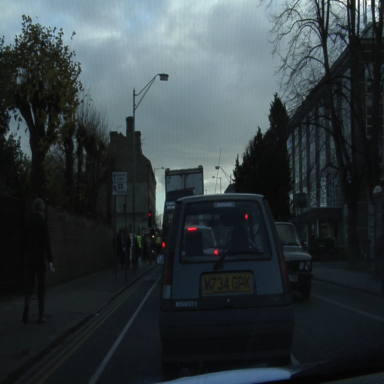

In [6]:
image_vis

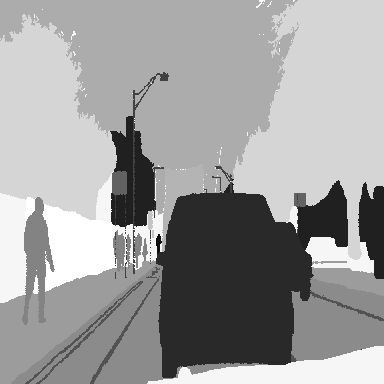

In [7]:
label_vis

### Main training loop

In [10]:
# Train the model
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = FCN8s(num_classes=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_classes = 32
writer = SummaryWriter()
loss_list = []
epoch_train_loss = []
early_stopping = EarlyStopping(tolerance=15, min_delta=0.01)
for epoch in range(num_epochs):
    for i, (images, labels) in (enumerate(train_loader)):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        epoch_train_loss.append(loss.item())

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), sum(loss_list)/len(loss_list)))
            loss_list = []

    train_loss = sum(epoch_train_loss)/len(epoch_train_loss)
    pixel_acc, mean_iou, freq_iou = calculate_metrics(torch.argmax(outputs, dim=1).cpu().numpy(), labels.cpu().numpy(), num_classes)
    print("Train")
    print('Pixel accuracy: {:.4f}, Mean IoU: {:.4f}, Frequency weighted IoU: {:.4f}'.format(pixel_acc, mean_iou, freq_iou))
    print('='*20)

    # eval the model        
    eval_loss, eval_pixel_acc, eval_mean_iou, eval_freq_iou = eval_model(model, val_loader, device)

    # Log performance
    writer.add_scalars("Loss", {"train": train_loss, "val": eval_loss}, epoch)
    writer.add_scalars("PixAcc", {"train": pixel_acc, "val": eval_pixel_acc}, epoch)
    writer.add_scalars("meanIOU", {"train": mean_iou, "val": eval_mean_iou}, epoch)
    # save the best model
    if eval_mean_iou >= early_stopping.best_loss:
        print("Saving best model...")
        early_stopping.best_loss = eval_mean_iou
        model_save_path = "best_model.pth"
        # save the model and the optimizer
        torch.save(model.state_dict(), model_save_path)
            
    early_stopping(eval_mean_iou)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break
writer.close()

cuda
Epoch [1/100], Step [10/93], Loss: 3.0387
Epoch [1/100], Step [20/93], Loss: 1.7180
Epoch [1/100], Step [30/93], Loss: 1.5126
Epoch [1/100], Step [40/93], Loss: 1.3731
Epoch [1/100], Step [50/93], Loss: 1.2291
Epoch [1/100], Step [60/93], Loss: 1.0517
Epoch [1/100], Step [70/93], Loss: 1.0206
Epoch [1/100], Step [80/93], Loss: 0.8641
Epoch [1/100], Step [90/93], Loss: 0.9598
Train
Pixel accuracy: 0.7038, Mean IoU: 0.1147, Frequency weighted IoU: 0.6151
Validation
Pixel accuracy: 0.7723, Mean IoU: 0.1177, Frequency weighted IoU: 0.6273, Val Loss: 0.8780
Saving best model...
EarlyStopping counter: 1 out of 15
Best mIoU: 0.11773582823478637, Current mIoU: 0.11773582823478637
Epoch [2/100], Step [10/93], Loss: 0.9106
Epoch [2/100], Step [20/93], Loss: 0.9614
Epoch [2/100], Step [30/93], Loss: 0.8413
Epoch [2/100], Step [40/93], Loss: 0.7430
Epoch [2/100], Step [50/93], Loss: 0.8583
Epoch [2/100], Step [60/93], Loss: 0.7058
Epoch [2/100], Step [70/93], Loss: 0.7640
Epoch [2/100], Step 

In [11]:
# load the best model
best_model = FCN8s(num_classes=32).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
eval_model(best_model, test_loader, device, save_pred=True)

Validation
Pixel accuracy: 0.9168, Mean IoU: 0.4159, Frequency weighted IoU: 0.8544, Val Loss: 0.5309
232 predictions saved at test_pred.npy


(0.5308546444465374,
 0.9168463812934028,
 0.41590775366099386,
 0.8543743050041521)

In [12]:
print('Visualizing the model on the test set, the results will be saved in the vis/ directory')
visualize_model(best_model, test_loader, device)

Visualizing the model on the test set, the results will be saved in the vis/ directory


100%|██████████| 58/58 [00:30<00:00,  1.91it/s]
